# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_018  I3L145;P04278    15.968
Sample_149  Q9NS84           12.615
Sample_202  Q9NY15           14.263
Sample_208  E7EQ64;P07477    16.638
Sample_204  Q01459           18.126
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups               
Sample_208  J3KSJ8;Q9UD71;Q9UD71-2          11.568
Sample_100  E5RK69;E7EMC6;P08133;P08133-2   12.420
Sample_190  Q9BWS9                          14.768
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.003
            A0A075B6Q5                 12.278
            A0A075B6R2                 12.370
            A0A075B6S5                 12.921
            A0A087WSY4                 13.675
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.443
            Q9UI40;Q9UI40-2            12.253
            Q9UIW2                     12.147
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.378
            Q9UP79                     12.432
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.481,15.050,16.842,19.863,16.556,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,17.067,19.067,...,15.528,15.576,14.385,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.863,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.111,17.705,17.039,15.911,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.157,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.235,15.345,17.084,18.708,14.249,19.433,11.866,11.624
Sample_207,15.739,16.877,15.469,16.898,14.407,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.003,...,16.012,15.178,12.912,15.050,16.842,19.863,12.612,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.415,19.067,16.188,...,15.528,15.576,11.294,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.027,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.445,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.275,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.451,15.345,17.084,18.708,14.249,19.433,13.010,11.974
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 355.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]

100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.95it/s]

100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.92it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.13it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.89it/s]

100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.06it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.26it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.89it/s]

100%|██████████| 6/6 [00:01<00:00,  2.83it/s]

100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.87it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.32it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  3.00it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.63it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.33it/s]

100%|██████████| 7/7 [00:02<00:00,  2.22it/s]

100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.21it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.63it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.09it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.69it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.50it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.93it/s]

100%|██████████| 8/8 [00:02<00:00,  2.45it/s]

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.02it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.40it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.72it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.53it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.44it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.42it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.12it/s]

 30%|███       | 3/10 [00:00<00:01,  4.10it/s]

 40%|████      | 4/10 [00:01<00:01,  3.54it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.30it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.24it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.22it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.13it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.10it/s]

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.87it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.85it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.23it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.06it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.92it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.87it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.88it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.93it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.51it/s]

100%|██████████| 11/11 [00:03<00:00,  2.30it/s]

100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.38it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.16it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.58it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.18it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.12it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.07it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.67it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.24it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.08it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.00it/s]

100%|██████████| 12/12 [00:04<00:00,  2.11it/s]

100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.55it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.65it/s]

 31%|███       | 4/13 [00:00<00:02,  4.12it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.86it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.70it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.47it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.24it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.91it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.64it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.31it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.09it/s]

100%|██████████| 13/13 [00:04<00:00,  1.96it/s]

100%|██████████| 13/13 [00:04<00:00,  2.73it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.69it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.73it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.75it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.36it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.39it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.49it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.59it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.84it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.65it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.36it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.31it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.44it/s]

100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.20it/s]

 20%|██        | 3/15 [00:00<00:02,  4.38it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.90it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.52it/s]

 40%|████      | 6/15 [00:01<00:02,  3.42it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.35it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.24it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.85it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.39it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.14it/s]

 80%|████████  | 12/15 [00:04<00:01,  1.91it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.79it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  1.88it/s]

100%|██████████| 15/15 [00:05<00:00,  2.16it/s]

100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.033 0.011          0.754 0.355       0.113   
2             0.007 0.006      0.084 0.035          0.702 0.096       0.599   
3             0.004 0.002      0.057 0.018          0.698 0.113       0.592   
4             0.004 0.002      0.047 0.012          0.673 0.092       0.641   
5             0.004 0.002      0.056 0.019          0.690 0.099       0.677   
6             0.005 0.004      0.065 0.022          0.789 0.091       0.789   
7             0.007 0.007      0.072 0.031          0.794 0.087       0.796   
8             0.006 0.005      0.079 0.027          0.796 0.087       0.802   
9             0.009 0.008      0.085 0.033          0.791 0.074       0.831   
10            0.007 0.005      0.075 0.029          0.791 0.075       0.833   
11            0.006 0.005      0.078 0.029          0.795 0.078       0.823   
12            0.005 0.003      0.063 0.022          0.804 0.079       0.816   
13            0.006 0.005      0.065 0.026          0.802 0.084       0.820   
14            0.006 0.004      0.074 0.035          0.797 0.085       0.811   
15            0.005 0.004      0.061 0.024          0.794 0.083       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.189 0.126                  0.549 0.039        0.845   
2          0.102   0.641 0.082                  0.704 0.062        0.777   
3          0.113   0.633 0.088                  0.698 0.066        0.780   
4          0.112   0.649 0.079                  0.704 0.062        0.779   
5          0.116   0.677 0.081                  0.724 0.066        0.792   
6          0.117   0.783 0.081                  0.815 0.068        0.888   
7          0.111   0.790 0.076                  0.821 0.065        0.887   
8          0.105   0.794 0.074                  0.824 0.063        0.891   
9          0.096   0.807 0.063                  0.834 0.056        0.908   
10         0.095   0.808 0.063                  0.835 0.056        0.907   
11         0.100   0.805 0.067                  0.833 0.059        0.905   
12         0.101   0.806 0.067                  0.834 0.057        0.913   
13         0.100   0.807 0.070                  0.835 0.060        0.911   
14         0.098   0.799 0.067                  0.828 0.057        0.909   
15         0.098   0.796 0.068                  0.825 0.058        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.813 0.095        210.000 0.000  
2          0.073                  0.753 0.089        210.000 0.000  
3          0.072                  0.728 0.099        210.000 0.000  
4          0.071                  0.728 0.096        210.000 0.000  
5          0.068                  0.754 0.098        210.000 0.000  
6          0.054                  0.850 0.071        210.000 0.000  
7          0.053                  0.849 0.070        210.000 0.000  
8          0.053                  0.863 0.065        210.000 0.000  
9          0.049                  0.896 0.048        210.000 0.000  
10         0.049                  0.896 0.050        210.000 0.000  
11         0.050                  0.893 0.051        210.000 0.000  
12         0.050                  0.905 0.048        210.000 0.000  
13         0.051                  0.902 0.049        210.000 0.000  
14         0.051                  0.900 0.049        210.000 0.000  
15         0.052                  0.898 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 507.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.57it/s]

100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.15it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.74it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.34it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.76it/s]

100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.66it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.02it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.74it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.25it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.81it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.27it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.84it/s]

100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.46it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.81it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.53it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.33it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.07it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.63it/s]

100%|██████████| 8/8 [00:02<00:00,  2.13it/s]

100%|██████████| 8/8 [00:02<00:00,  2.73it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.87it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.75it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.32it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.12it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.01it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.89it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.89it/s]

100%|██████████| 9/9 [00:02<00:00,  2.93it/s]

100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.78it/s]

 30%|███       | 3/10 [00:00<00:02,  3.24it/s]

 40%|████      | 4/10 [00:01<00:02,  2.73it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.60it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.50it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.38it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.39it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.50it/s]

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.99it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.73it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.03it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.22it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.26it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.38it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.30it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.21it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.37it/s]

100%|██████████| 11/11 [00:04<00:00,  2.49it/s]

100%|██████████| 11/11 [00:04<00:00,  2.55it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.50it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.36it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.37it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.31it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.29it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.25it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.15it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.11it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.20it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.21it/s]

100%|██████████| 12/12 [00:05<00:00,  2.29it/s]

100%|██████████| 12/12 [00:05<00:00,  2.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.20it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.83it/s]

 31%|███       | 4/13 [00:01<00:02,  3.34it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.71it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.72it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.74it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.77it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.76it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.36it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.09it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.07it/s]

100%|██████████| 13/13 [00:05<00:00,  2.01it/s]

100%|██████████| 13/13 [00:05<00:00,  2.48it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.96it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.26it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.10it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.97it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.82it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.43it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.14it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.99it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.99it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.06it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.21it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.33it/s]

100%|██████████| 14/14 [00:05<00:00,  2.24it/s]

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.71it/s]

 20%|██        | 3/15 [00:00<00:02,  4.28it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.65it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.70it/s]

 40%|████      | 6/15 [00:01<00:03,  2.79it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.72it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.68it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.83it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.78it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.76it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.77it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.80it/s]

100%|██████████| 15/15 [00:05<00:00,  2.85it/s]

100%|██████████| 15/15 [00:05<00:00,  2.93it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.074 0.027          0.117 0.284       0.012   
2             0.005 0.003      0.067 0.026          0.707 0.092       0.634   
3             0.007 0.006      0.087 0.033          0.695 0.077       0.662   
4             0.005 0.005      0.058 0.022          0.691 0.077       0.662   
5             0.004 0.002      0.051 0.011          0.713 0.087       0.650   
6             0.005 0.003      0.056 0.016          0.767 0.094       0.698   
7             0.005 0.004      0.059 0.019          0.797 0.087       0.802   
8             0.006 0.005      0.064 0.022          0.798 0.088       0.808   
9             0.005 0.004      0.062 0.021          0.799 0.093       0.803   
10            0.005 0.004      0.053 0.013          0.797 0.094       0.803   
11            0.004 0.002      0.049 0.008          0.798 0.090       0.807   
12            0.005 0.002      0.059 0.019          0.795 0.087       0.807   
13            0.006 0.004      0.059 0.018          0.797 0.086       0.805   
14            0.005 0.003      0.053 0.017          0.802 0.078       0.790   
15            0.004 0.002      0.049 0.011          0.821 0.082       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.029   0.021 0.051                  0.502 0.013        0.875   
2          0.094   0.664 0.074                  0.719 0.059        0.799   
3          0.125   0.672 0.085                  0.724 0.064        0.818   
4          0.126   0.669 0.084                  0.722 0.063        0.815   
5          0.114   0.674 0.084                  0.728 0.063        0.819   
6          0.102   0.726 0.080                  0.770 0.063        0.845   
7          0.101   0.794 0.067                  0.823 0.057        0.912   
8          0.103   0.797 0.069                  0.827 0.058        0.910   
9          0.104   0.796 0.072                  0.825 0.061        0.908   
10         0.102   0.794 0.070                  0.824 0.059        0.905   
11         0.107   0.796 0.071                  0.826 0.060        0.906   
12         0.109   0.795 0.069                  0.825 0.058        0.905   
13         0.109   0.794 0.067                  0.825 0.056        0.906   
14         0.105   0.790 0.064                  0.821 0.053        0.912   
15         0.091   0.817 0.057                  0.843 0.049        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.841 0.086        210.000 0.000  
2          0.061                  0.751 0.091        210.000 0.000  
3          0.057                  0.773 0.084        210.000 0.000  
4          0.057                  0.770 0.083        210.000 0.000  
5          0.058                  0.785 0.081        210.000 0.000  
6          0.052                  0.819 0.069        210.000 0.000  
7          0.044                  0.892 0.054        210.000 0.000  
8          0.045                  0.890 0.056        210.000 0.000  
9          0.045                  0.888 0.055        210.000 0.000  
10         0.047                  0.886 0.057        210.000 0.000  
11         0.046                  0.887 0.055        210.000 0.000  
12         0.046                  0.885 0.056        210.000 0.000  
13         0.047                  0.889 0.054        210.000 0.000  
14         0.045                  0.892 0.054        210.000 0.000  
15         0.037                  0.908 0.041 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 907.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 16.78it/s]

100%|██████████| 3/3 [00:00<00:00, 13.96it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.39it/s]

100%|██████████| 4/4 [00:00<00:00, 20.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.61it/s]

100%|██████████| 5/5 [00:00<00:00, 19.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 28.56it/s]

100%|██████████| 6/6 [00:00<00:00, 25.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.71it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 22.90it/s]

100%|██████████| 7/7 [00:00<00:00, 22.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 29.33it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 24.03it/s]

100%|██████████| 8/8 [00:00<00:00, 24.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 24.79it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 20.54it/s]

100%|██████████| 9/9 [00:00<00:00, 20.23it/s]

100%|██████████| 9/9 [00:00<00:00, 20.62it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 28.28it/s]

 70%|███████   | 7/10 [00:00<00:00, 25.79it/s]

100%|██████████| 10/10 [00:00<00:00, 18.09it/s]

100%|██████████| 10/10 [00:00<00:00, 19.94it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.23it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.62it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 19.32it/s]

100%|██████████| 11/11 [00:00<00:00, 16.91it/s]

100%|██████████| 11/11 [00:00<00:00, 17.63it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.95it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.08it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.57it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.80it/s]

100%|██████████| 12/12 [00:00<00:00, 16.52it/s]

100%|██████████| 12/12 [00:00<00:00, 16.85it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 29.57it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 24.55it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 22.70it/s]

100%|██████████| 13/13 [00:00<00:00, 21.82it/s]

100%|██████████| 13/13 [00:00<00:00, 22.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 29.00it/s]

 50%|█████     | 7/14 [00:00<00:00, 22.75it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 21.57it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 20.96it/s]

100%|██████████| 14/14 [00:00<00:00, 22.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 38.04it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 30.82it/s]

 80%|████████  | 12/15 [00:00<00:00, 29.05it/s]

100%|██████████| 15/15 [00:00<00:00, 28.55it/s]

100%|██████████| 15/15 [00:00<00:00, 29.49it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.048 0.010          0.000 0.000       0.000   
2             0.004 0.000      0.045 0.004          0.030 0.109       0.006   
3             0.004 0.002      0.050 0.012          0.199 0.356       0.022   
4             0.003 0.001      0.041 0.007          0.702 0.092       0.622   
5             0.003 0.001      0.035 0.009          0.734 0.102       0.677   
6             0.003 0.001      0.031 0.005          0.735 0.092       0.684   
7             0.003 0.001      0.032 0.007          0.713 0.092       0.656   
8             0.002 0.001      0.029 0.006          0.708 0.082       0.659   
9             0.002 0.000      0.027 0.001          0.722 0.086       0.677   
10            0.004 0.003      0.044 0.019          0.707 0.075       0.673   
11            0.004 0.001      0.045 0.016          0.709 0.078       0.672   
12            0.003 0.001      0.035 0.009          0.700 0.083       0.666   
13            0.002 0.000      0.028 0.002          0.723 0.078       0.710   
14            0.002 0.000      0.027 0.000          0.726 0.088       0.712   
15            0.002 0.000      0.028 0.002          0.720 0.084       0.697   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.719   
2          0.021   0.009 0.033                  0.494 0.017        0.628   
3          0.039   0.037 0.061                  0.496 0.022        0.552   
4          0.120   0.654 0.093                  0.714 0.068        0.810   
5          0.116   0.698 0.095                  0.747 0.070        0.828   
6          0.112   0.703 0.088                  0.750 0.065        0.826   
7          0.126   0.676 0.094                  0.730 0.066        0.821   
8          0.119   0.676 0.084                  0.729 0.062        0.820   
9          0.125   0.693 0.091                  0.742 0.070        0.818   
10         0.124   0.684 0.090                  0.735 0.067        0.825   
11         0.131   0.683 0.095                  0.735 0.068        0.822   
12         0.123   0.677 0.093                  0.728 0.070        0.819   
13         0.120   0.710 0.083                  0.754 0.065        0.824   
14         0.128   0.711 0.090                  0.756 0.070        0.822   
15         0.142   0.700 0.106                  0.748 0.076        0.819   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.685 0.072        210.000 0.000  
2          0.098                  0.574 0.099        210.000 0.000  
3          0.104                  0.516 0.097        210.000 0.000  
4          0.059                  0.756 0.074        210.000 0.000  
5          0.059                  0.775 0.081        210.000 0.000  
6          0.058                  0.768 0.082        210.000 0.000  
7          0.062                  0.762 0.085        210.000 0.000  
8          0.059                  0.768 0.077        210.000 0.000  
9          0.059                  0.775 0.071        210.000 0.000  
10         0.058                  0.773 0.077        210.000 0.000  
11         0.058                  0.770 0.077        210.000 0.000  
12         0.058                  0.769 0.073        210.000 0.000  
13         0.060                  0.781 0.074        210.000 0.000  
14         0.064                  0.782 0.077        210.000 0.000  
15         0.064                  0.775 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,3,3
score_time,9,3,3
test_precision,12,15,6
test_recall,10,15,14
test_f1,10,15,14
test_balanced_accuracy,10,15,14
test_roc_auc,12,15,5
test_average_precision,12,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.17it/s]

 20%|██        | 3/15 [00:00<00:01,  6.39it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.65it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.31it/s]

 40%|████      | 6/15 [00:01<00:01,  5.41it/s]

 47%|████▋     | 7/15 [00:01<00:01,  5.48it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.55it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.60it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.61it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.64it/s]

 80%|████████  | 12/15 [00:02<00:00,  5.66it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.68it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.68it/s]

100%|██████████| 15/15 [00:02<00:00,  5.67it/s]

100%|██████████| 15/15 [00:02<00:00,  5.72it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 36.43it/s]

100%|██████████| 5/5 [00:00<00:00, 33.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.60it/s]

 33%|███▎      | 4/12 [00:00<00:00,  8.34it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.73it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.36it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.20it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  7.03it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.95it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.90it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.90it/s]

100%|██████████| 12/12 [00:01<00:00,  6.86it/s]

100%|██████████| 12/12 [00:01<00:00,  7.30it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


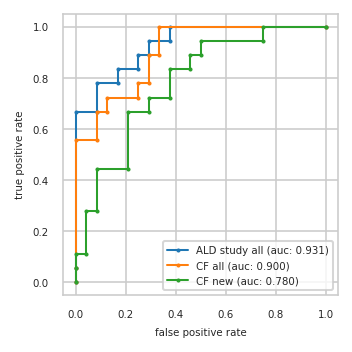

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.667  0.000 0.556  0.000 0.111
3          0.083 0.667  0.083 0.556  0.042 0.111
4          0.083 0.778  0.083 0.667  0.042 0.278
5          0.167 0.778  0.125 0.667  0.083 0.278
6          0.167 0.833  0.125 0.722  0.083 0.444
7          0.250 0.833  0.250 0.722  0.208 0.444
8          0.250 0.889  0.250 0.778  0.208 0.667
9          0.292 0.889  0.292 0.778  0.292 0.667
10         0.292 0.944  0.292 0.889  0.292 0.722
11         0.375 0.944  0.333 0.889  0.375 0.722
12         0.375 1.000  0.333 1.000  0.375 0.833
13         1.000 1.000  1.000 1.000  0.458 0.833
14           NaN   NaN    NaN   NaN  0.458 0.889
15           NaN   NaN    NaN   NaN  0.500 0.889
16           NaN   NaN    NaN   NaN  0.500 0.944
17           NaN   NaN    NaN   NaN  0.750 0.944
18           NaN   NaN    NaN   NaN  0.750 1.000
19           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,H0YLF3,Q9GZT8;Q9GZT8-2
2,P09486,P02741,P51688
3,K7ERG9;P00746,A0A087WU43;A0A087WX17;A0A087WXI5;P12830;P12830-2,Q16799
4,P14174,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
5,P10636-2;P10636-6,P61981,None
6,P61981,P04075,None
7,Q6EMK4,P14174,None
8,P14618,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


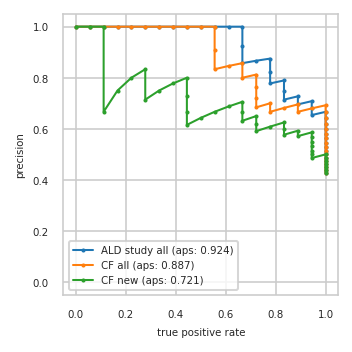

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.621 1.000     0.586 0.944
14         0.643 1.000     0.643 1.000     0.571 0.889
15         0.667 1.000     0.667 1.000     0.593 0.889
16         0.654 0.944     0.692 1.000     0.577 0.833
17         0.680 0.944     0.680 0.944     0.600 0.833
18         0.708 0.944     0.667 0.889     0.625 0.833
19         0.696 0.889     0.696 0.889     0.609 0.778
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.750 0.833     0.700 0.778     0.650 0.722
23         0.789 0.833     0.684 0.722     0.632 0.667
24         0.778 0.778     0.722 0.722     0.667 0.667
25         0.824 0.778     0.765 0.722     0.706 0.667
26         0.875 0.778     0.812 0.722     0.688 0.611
27         0.867 0.722     0.800 0.667     0.667 0.556
28         0.857 0.667     0.857 0.667     0.643 0.500
29         0.923 0.667     0.846 0.611     0.615 0.444
30         1.000 0.667     0.833 0.556     0.667 0.444
31         1.000 0.611     0.909 0.556     0.727 0.444
32         1.000 0.556     1.000 0.556     0.800 0.444
33         1.000 0.500     1.000 0.500     0.778 0.389
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


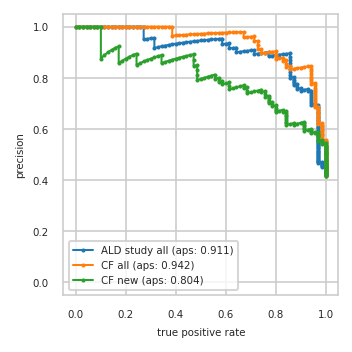

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


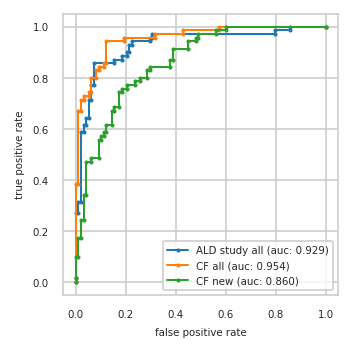

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}